<a href="https://colab.research.google.com/github/mahmoudelhout86/Customer_Loyality_DEPI_SHR2_AIS4_G1/blob/master/Final_Project_Merchants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c elo-merchant-category-recommendation

In [ ]:
!unzip elo-merchant-category-recommendation.zip

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Importing Libraries</b>

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Defining Functions</b>

In [ ]:
def IQROutlierCheck(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q1 + 1.5 * IQR
    critic_score_outliers = df[(df[col] < lower) | (df[col] > upper)]

    return critic_score_outliers

In [ ]:
def OutliersInfo(df, cols):

    outlier_dict=dict()
    for col in cols:
        print(f"\n{col}")
        print("-"*35)
        critic_outliers = IQROutlierCheck(df, col)
        outlier_dict[col] = critic_outliers.index
        print(f"Number of outlier samples produced by IQR is {critic_outliers[col].shape[0]}")
        for i in range(0, 2):

            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))
        for i in range(98, 101):
            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))

        percent = np.percentile(df[col], 1)
        count = len(df[df[col]<percent])
        print(f"\n\t- Number of values less than {percent} is {count}")
        percent = np.percentile(df[col], 99)
        count = len(df[df[col]>percent])
        print(f"\t- Number of values greater than {percent} is {count}")

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Reading Dataset</b>

In [ ]:
# Reading the dataset and Displaying the first rows of the data

merchants = pd.read_csv('/content/merchants.csv')
merchants.head(3)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [ ]:
# Displaying the shape of the data

merchants.shape

(334696, 22)

In [ ]:
# Define data types for each column to reduce memory usage

dtypes = {
    'merchant_id': 'category',
    'merchant_group_id': 'int32',
    'merchant_category_id': 'int16',
    'subsector_id': 'int8',
    'numerical_1': 'float32',
    'numerical_2': 'float32',
    'category_1': 'category',
    'most_recent_sales_range': 'category',
    'most_recent_purchases_range': 'category',
    'avg_sales_lag3': 'float32',
    'avg_purchases_lag3': 'float64',
    'active_months_lag3': 'int8',
    'avg_sales_lag6': 'float32',
    'avg_purchases_lag6': 'float64',
    'active_months_lag6': 'int8',
    'avg_sales_lag12': 'float32',
    'avg_purchases_lag12': 'float64',
    'active_months_lag12': 'int8',
    'category_4': 'category',
    'city_id': 'int16',
    'state_id': 'int8',
    'category_2': 'float32'
}

In [ ]:
# Displaying descriptive statistics of the 'merchants' dataframe

merchants.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,322809.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,102.917926,11.860942,2.380002
std,31623.043426,252.898046,9.807371,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,107.090673,6.176889,1.562661
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,-1.000000,-1.000000,1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,69.000000,9.000000,2.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,347.000000,24.000000,5.000000


In [ ]:
# Drop uninformative and redundant columns

merchants = merchants.drop(['merchant_group_id','merchant_category_id','city_id',
                            'avg_sales_lag3','avg_purchases_lag3','active_months_lag3','avg_sales_lag6','avg_purchases_lag6','active_months_lag6'],axis= 1)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Duplicated Values</b>

In [ ]:
# Checking duplication in 'merchant_id' column

print(merchants['merchant_id'].shape[0])
print(merchants['merchant_id'].nunique())

334696
334633


In [ ]:
# Remove duplicate rows on 'merchant_id' column

merchants.drop_duplicates(subset='merchant_id',inplace=True)

In [ ]:
# Checking duplication after dropping the duplicated rows

merchants.duplicated().sum()

np.int64(0)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Missing Values</b>

In [ ]:
# Checking null values in each column in merchant DataFrame

merchants.isnull().sum()

,0
merchant_id,0
subsector_id,0
numerical_1,0
numerical_2,0
category_1,0
most_recent_sales_range,0
most_recent_purchases_range,0
avg_sales_lag12,13
avg_purchases_lag12,0
active_months_lag12,0


In [ ]:
# Drop rows with null values in 'avg_sales_lag12' column

merchants.dropna(subset='avg_sales_lag12',inplace=True)

In [ ]:
# Calculate the mode of 'category_2' column

category_2_mode = merchants['category_2'].mode()[0]

print(f"Most Common in category_2 : {category_2_mode}")

Most Common in category_2 : 1.0


In [ ]:
# Fill null values in 'category_2' column with its mode

merchants['category_2'].fillna(category_2_mode, inplace=True)

<ipython-input-37-741a55efc228>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merchants['category_2'].fillna(category_2_mode, inplace=True)


In [ ]:
# Checking the missing values after dropping the nulls

merchants.isnull().sum()

,0
merchant_id,0
subsector_id,0
numerical_1,0
numerical_2,0
category_1,0
most_recent_sales_range,0
most_recent_purchases_range,0
avg_sales_lag12,0
avg_purchases_lag12,0
active_months_lag12,0


In [ ]:
# Iterate through each column and check for infinity values

for col in merchants.columns:
    has_inf = np.isinf(pd.to_numeric(merchants[col], errors='coerce')).any().any()
    if has_inf:
        print(f"{col} contains infinity values.")

In [ ]:
merchants.describe()

,subsector_id,numerical_1,numerical_2,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,state_id,category_2
count,334620.000000,334620.000000,334620.000000,3.346200e+05,334620.000000,334620.000000,334620.000000,334620.000000
mean,25.117339,0.010432,0.007178,2.522934e+01,2.062439,11.599567,11.861879,2.331182
std,9.807004,1.047074,1.031545,5.252336e+03,87.986943,1.519502,6.176019,1.555806
min,-1.000000,-0.057471,-0.057471,-8.213000e+01,0.098330,1.000000,-1.000000,1.000000
25%,19.000000,-0.057471,-0.057471,8.500000e-01,0.898333,12.000000,9.000000,1.000000
50%,27.000000,-0.057471,-0.057471,1.020000e+00,1.043338,12.000000,9.000000,1.000000
75%,33.000000,-0.047556,-0.047556,1.290000e+00,1.266361,12.000000,16.000000,4.000000
max,41.000000,183.735111,182.079322,2.567408e+06,50215.555556,12.000000,24.000000,5.000000


<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Outliers</b>

In [ ]:
# Display information about outliers

col = ['numerical_1','numerical_2','avg_sales_lag12','avg_purchases_lag12']
OutliersInfo(merchants, col)


numerical_1
-----------------------------------
Number of outlier samples produced by IQR is 64348
0% percentile value is -0.057
1% percentile value is -0.057
98% percentile value is 0.478
99% percentile value is 1.063
100% percentile value is 183.735

	- Number of values less than -0.05747065 is 0
	- Number of values greater than 1.06291354 is 3320

numerical_2
-----------------------------------
Number of outlier samples produced by IQR is 52674
0% percentile value is -0.057
1% percentile value is -0.057
98% percentile value is 0.458
99% percentile value is 1.043
100% percentile value is 182.079

	- Number of values less than -0.05747065 is 0
	- Number of values greater than 1.04308373 is 3318

avg_sales_lag12
-----------------------------------
Number of outlier samples produced by IQR is 56762
0% percentile value is -82.130
1% percentile value is 0.360
98% percentile value is 10.296
99% percentile value is 23.906
100% percentile value is 2567408.000

	- Number of values less than 

In [ ]:
# Filter merchants DataFrame based on specific conditions

merchants = merchants[(merchants['numerical_1'] < 2)]
merchants = merchants[(merchants['avg_sales_lag12'] > 0.36) & (merchants['avg_sales_lag12'] < 25)]
merchants = merchants[(merchants['avg_purchases_lag12'] > 0.45) & (merchants['avg_purchases_lag12'] < 25)]
merchants.shape

(324029, 13)

In [ ]:
# Calculate the correlation matrix for numerical features

num_features = merchants.select_dtypes(exclude='object')
corrleations = num_features.corr()
corrleations

,subsector_id,numerical_1,numerical_2,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,state_id,category_2
subsector_id,1.000000,-0.019072,-0.013157,0.006462,0.015966,-0.015977,0.014417,-0.012023
numerical_1,-0.019072,1.000000,0.987815,-0.028568,-0.024273,0.053987,0.002513,0.002744
numerical_2,-0.013157,0.987815,1.000000,-0.026335,-0.022640,0.051405,0.001291,0.000765
avg_sales_lag12,0.006462,-0.028568,-0.026335,1.000000,0.786052,-0.102935,0.014848,0.008070
avg_purchases_lag12,0.015966,-0.024273,-0.022640,0.786052,1.000000,-0.095336,0.017117,0.007634
active_months_lag12,-0.015977,0.053987,0.051405,-0.102935,-0.095336,1.000000,0.005635,0.000379
state_id,0.014417,0.002513,0.001291,0.014848,0.017117,0.005635,1.000000,0.120382
category_2,-0.012023,0.002744,0.000765,0.008070,0.007634,0.000379,0.120382,1.000000


In [ ]:
# Drop the 'numerical_2' column

merchants = merchants.drop(columns='numerical_2',axis=1)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:160%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400;
            text-align:
            center;"><b>Visualization</b>

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Create function for categorical features</b>

In [ ]:
colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
palette_color  = sns.color_palette("RdBu",10)
sns.set_theme(style="whitegrid", palette=palette_color)

def bar_plot(counts, column, ax, orient='v'):

    if orient=='h':
        x_col = 'count'
        y_col = column
    else:
        x_col = column
        y_col = 'count'

    sns.barplot(data = counts, x=x_col, y=y_col, ax=ax, orient=orient)


    if orient == 'v':
        # Annotate each bar with its height (number of occurrences)
        for p in ax.patches:
            x_coor = p.get_x() + 0.5 * p.get_width()
            y_coor = p.get_height()
            hight = int(p.get_height())

            ax.annotate(hight,            # Text to be displayed (converted to int for formatting)
                        (x_coor, y_coor), # Coordinates of the annotation (x, y)
                        ha='center',      # Horizontal alignment of the text ('center' aligns it at the center of the x-coordinate)
                        va='bottom',      # Vertical alignment of the text ('bottom' aligns it at the bottom of the bar)
                        color='black'     # Color of the text
                        )
        ax.set_xlabel(column, weight = "bold",  fontsize = 14, labelpad = 20)
        ax.set_ylabel('Number of Occurrences', weight = "bold", fontsize = 14, labelpad = 20)

    ax.tick_params(axis = 'both', labelsize = 12)

    return ax

In [ ]:
def plot_categorical_feature(counts, figsize=(12,5)):
   column = counts.columns[0]

   # Create a figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

   # Bar chart
   bar_plot(counts, column, ax1)

   # Pie chart
   ax2.pie(counts['count'], labels=counts[column], autopct = '%1.1f%%')
   ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
   ax2.legend(counts[column], loc="best") # Add legned with labels

   # Adjust layout
   plt.suptitle(f'Distribution of {column}', weight = "bold", fontsize = 16)
   plt.tight_layout()
   plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Top 25 Subsectors</b>

In [ ]:
Subsector_ID_Counts = merchants['subsector_id'].value_counts().head(25).reset_index()
Subsector_ID_Counts_sorted = Subsector_ID_Counts.sort_values(by='count',ascending=False)
Subsector_ID_Counts_sorted

,subsector_id,count
0,27,49926
1,37,34501
2,33,30214
3,34,25645
4,21,23416
5,29,20743
6,19,20023
7,16,16170
8,18,13760
9,20,9193


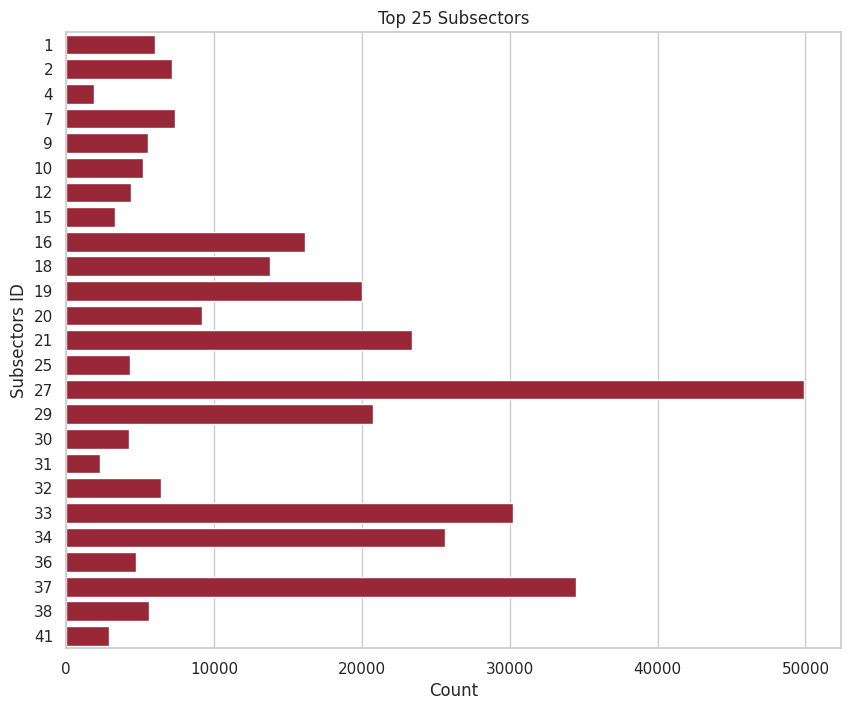

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(data=Subsector_ID_Counts_sorted,x='count',y='subsector_id' ,orient='h')
plt.title('Top 25 Subsectors')
plt.xlabel('Count')
plt.ylabel('Subsectors ID')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 1</b>

In [ ]:
category_1_count = merchants['category_1'].value_counts().reset_index()
category_1_count

,category_1,count
0,N,317489
1,Y,6540


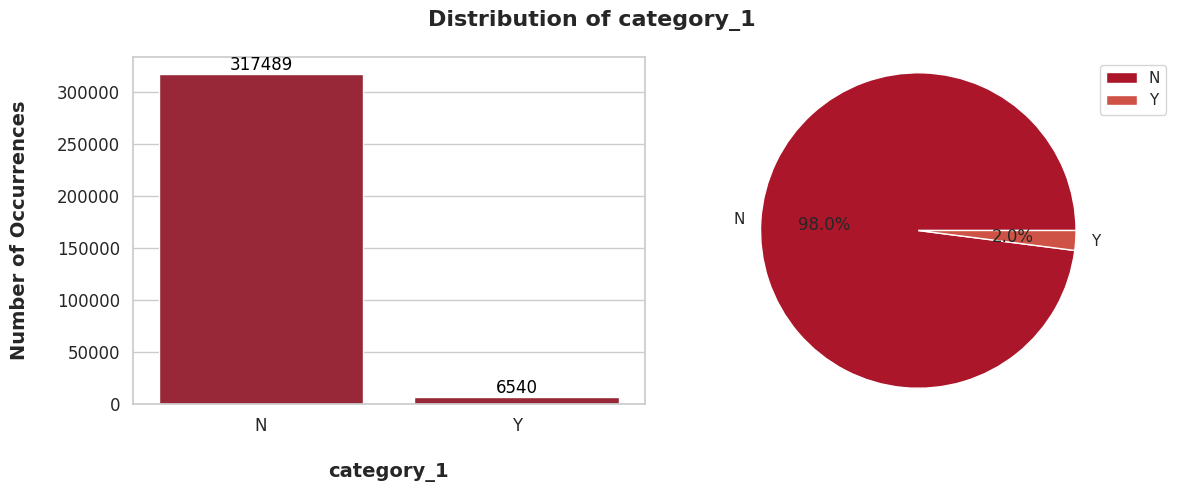

In [ ]:
plot_categorical_feature(category_1_count)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Most Recent Sales Range</b>

In [ ]:
most_recent_sales_range_count = merchants['most_recent_sales_range'].value_counts().reset_index()
most_recent_sales_range_count

,most_recent_sales_range,count
0,E,171030
1,D,115004
2,C,33358
3,B,3945
4,A,692


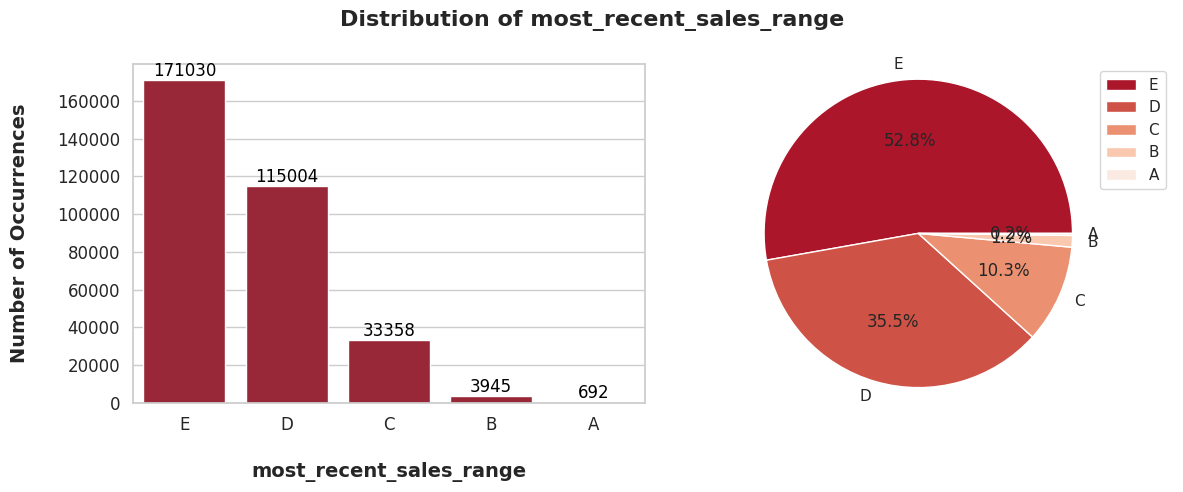

In [ ]:
plot_categorical_feature(most_recent_sales_range_count)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Most Recent Purchase Range</b>

In [ ]:
most_recent_purchases_range_count = merchants['most_recent_purchases_range'].value_counts().reset_index()
most_recent_purchases_range_count

,most_recent_purchases_range,count
0,E,167949
1,D,117878
2,C,33324
3,B,4280
4,A,598


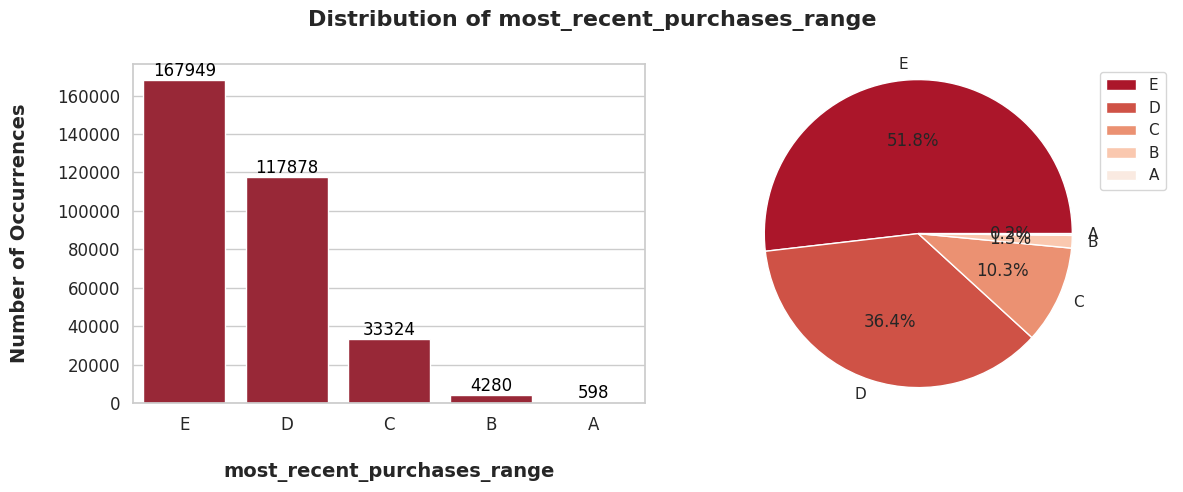

In [ ]:
plot_categorical_feature(most_recent_purchases_range_count)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Counts of Active Month Lag</b>

In [ ]:
active_months_lag12_count = merchants['active_months_lag12'].value_counts().reset_index()
active_months_lag12_count

,active_months_lag12,count
0,12,296920
1,11,4017
2,10,3772
3,9,3485
4,8,3412
5,7,3008
6,6,2493
7,5,2096
8,4,1878
9,3,1544


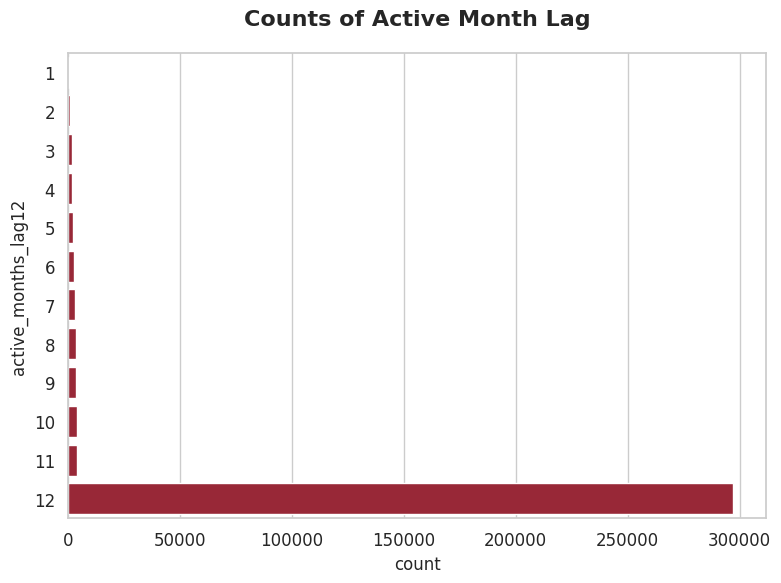

In [ ]:
plt.figure(figsize=(8,6))
bar_plot(active_months_lag12_count,column='active_months_lag12',ax=plt.gca(),orient='h')
plt.title('Counts of Active Month Lag', weight = "bold", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 4</b>

In [ ]:
category_4_count = merchants['category_4'].value_counts().reset_index()
category_4_count

,category_4,count
0,N,231756
1,Y,92273


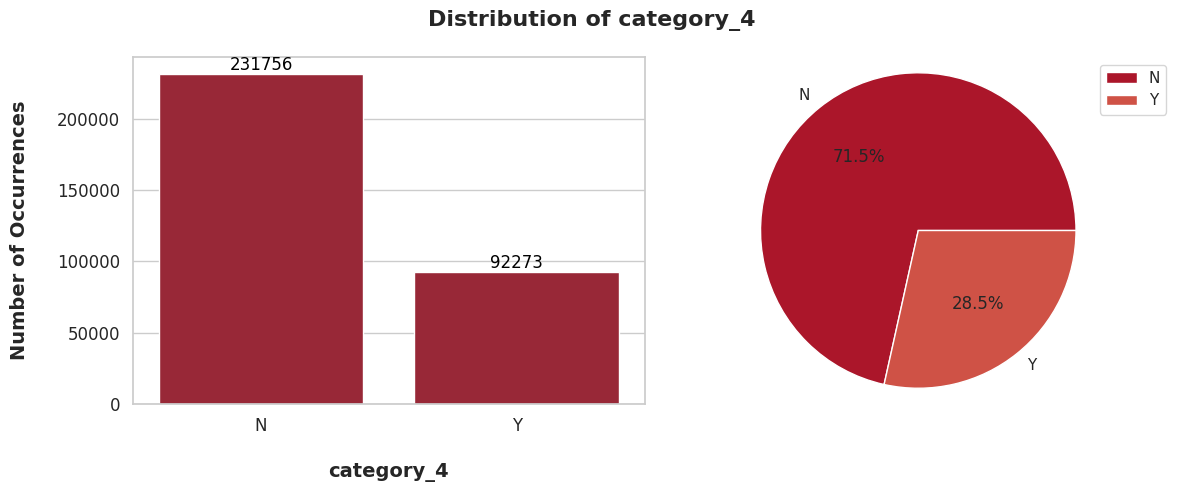

In [ ]:
plot_categorical_feature(category_4_count)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 2</b>

In [ ]:
category_2_count = merchants['category_2'].value_counts().reset_index()
category_2_count

,category_2,count
0,1.0,167278
1,5.0,51254
2,3.0,50177
3,4.0,35255
4,2.0,20065


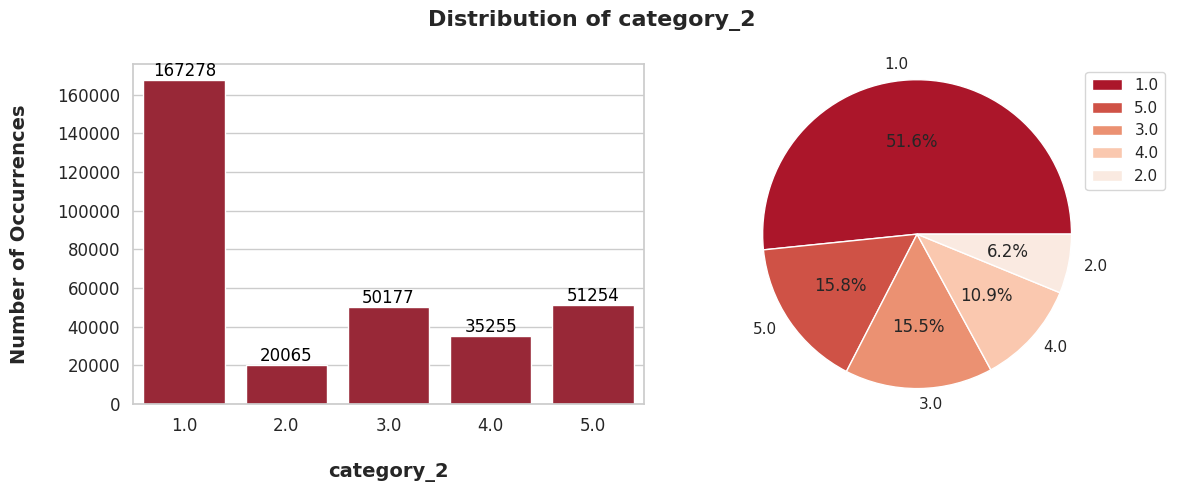

In [ ]:
plot_categorical_feature(category_2_count)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Feature Encoding</b>

In [ ]:
# Encode categorical features to numerical

merchants['category_1'] = merchants['category_1'].map({'Y' : 1 , 'N' : 0})
merchants['category_4'] = merchants['category_4'].map({'Y' : 1 , 'N' : 0})

merchants['most_recent_sales_range'] = merchants['most_recent_sales_range'].map({'A': 1 , 'B': 2 , 'C': 3 , 'D': 4 , 'E': 5})
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range'].map({'A': 1 , 'B': 2 , 'C': 3 , 'D': 4 , 'E': 5})

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Features Aggregations</b>

In [ ]:
# Create Aggregation dictionary to define how to aggregate columns

aggregation = {
    'subsector_id': ['nunique',statistics.mode],
    'numerical_1':['mean','max','min','sum',statistics.mode],
    'category_1':[statistics.mode,'mean','sum'],
    'most_recent_sales_range':[statistics.mode,'mean','sum'],
    'most_recent_purchases_range':[statistics.mode,'mean','sum'],
    'avg_sales_lag12':['mean','sum','max','min'],
    'avg_purchases_lag12':['mean','sum','max','min'],
    'active_months_lag12':['mean','sum','max','min'],
    'category_4':[statistics.mode,'mean','sum'],
    'state_id':[statistics.mode,'nunique'],
    'category_2':[statistics.mode,'mean','sum'],
}

In [ ]:
# Group the 'merchants' by 'merchant_id' and apply the aggregations

aggregate_merchants = merchants.groupby('merchant_id').agg(aggregation)
aggregate_merchants.head(3)

subsector_id      numerical_1                                \
                     nunique mode        mean       max       min       sum   
merchant_id                                                                   
M_ID_000025127f            1   37   -0.057471 -0.057471 -0.057471 -0.057471   
M_ID_0000699140            1   27   -0.057471 -0.057471 -0.057471 -0.057471   
M_ID_00006a5552            1   29   -0.057471 -0.057471 -0.057471 -0.057471   

                          category_1           ... active_months_lag12      \
                     mode       mode mean sum  ...                 max min   
merchant_id                                    ...                           
M_ID_000025127f -0.057471          0  0.0   0  ...                  12  12   
M_ID_0000699140 -0.057471          0  0.0   0  ...                  12  12   
M_ID_00006a5552 -0.057471          0  0.0   0  ...                  12  12   

                category_4          state_id         category_2            
                      mode mean sum     mode nunique       mode mean  sum  
merchant_id                                                                
M_ID_000025127f          1  1.0   1        9       1        1.0  1.0  1.0  
M_ID_0000699140          0  0.0   0        9       1        1.0  1.0  1.0  
M_ID_00006a5552          0  0.0   0       15       1        1.0  1.0  1.0  

[3 rows x 36 columns]

In [ ]:
# Rename the columns of the 'aggregate_merchants' DataFrame

aggregate_merchants.columns = [str(uppers)+'_'+str(lowers).strip() for uppers,lowers in aggregate_merchants.columns.values]
aggregate_merchants  =aggregate_merchants.reset_index()
aggregate_merchants.head(3)

,merchant_id,subsector_id_nunique,subsector_id_mode,numerical_1_mean,numerical_1_max,numerical_1_min,numerical_1_sum,numerical_1_mode,category_1_mode,category_1_mean,...,active_months_lag12_max,active_months_lag12_min,category_4_mode,category_4_mean,category_4_sum,state_id_mode,state_id_nunique,category_2_mode,category_2_mean,category_2_sum
0,M_ID_000025127f,1,37,-0.057471,-0.057471,-0.057471,-0.057471,-0.057471,0,0.0,...,12,12,1,1.0,1,9,1,1.0,1.0,1.0
1,M_ID_0000699140,1,27,-0.057471,-0.057471,-0.057471,-0.057471,-0.057471,0,0.0,...,12,12,0,0.0,0,9,1,1.0,1.0,1.0
2,M_ID_00006a5552,1,29,-0.057471,-0.057471,-0.057471,-0.057471,-0.057471,0,0.0,...,12,12,0,0.0,0,15,1,1.0,1.0,1.0


In [ ]:
# Display the number of rows and columns of 'aggregate_merchants'

aggregate_merchants.shape

(324029, 37)

In [ ]:
# Save the 'aggregate_merchants' DataFrame to CSV file without the Index

aggregate_merchants.to_csv('/content/drive/MyDrive/ColabNotebooks/aggregate_merchants.csv', index=False)
print("Aggregate Merchants Saved")

Aggregate Merchants Saved
